## Creating Custom Datasets and Finetuning Pre-trained Networks
In this notebook you have to create custom datasets for PyTorch and use this dataset to finetune certain pre-trained neural networks and observe the results.

In [11]:
# Import Statements
#
# Several of the imports you will need have been added but you will need to provide the
# rest yourself; you should be able to figure out most of the imports as you go through
# the notebook since without proper imports your code will fail to run
#
# All import statements go in this block

from __future__ import division, print_function, unicode_literals
import numpy as np
import torch
import torch.utils.data
import torchvision.models as models
import torchvision.transforms as transforms
import os
import torchvision
import torch.nn as nn
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

All hyper parameters go in the next block

In [12]:
batch_size = 100
num_epochs = 5
learning_rate = 0.01

### Creating Custom Datasets
Your first task is to create a pipeline for the custom dataset so that you can load it using a dataloader. Download the dataset provided in the assignment webpage and complete the following block of code so that you can load it as if it was a standard dataset.

In [13]:
class CDATA(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
    def __init__(self, root_dir, train, transform=None):
        # root_dir  - the root directory of the dataset
        # train     - a boolean parameter representing whether to return the training set or the test set
        # transform - the transforms to be applied on the images before returning them
        #
        # In this function store the parameters in instance variables and make a mapping
        # from images to labels and keep it as an instance variable. Make sure to check which
        # dataset is required; train or test; and create the mapping accordingly.
        
        self.root_dir = root_dir
        self.train = train
        self.transform = transform
        if train == True:
            dir1 = '/train/'
        else:
            dir1 = '/test/'
        
        dir_names = os.listdir(root_dir + dir1)
        img_names=[]
        labels = []
        count = 0
        for c in dir_names:
            names = os.listdir(root_dir + dir1 + c)
            N = len(names)
            for n in range(N):
                img_names.append(str(root_dir + dir1 + c + '/' + names[n]))
                labels += [count]
            count+=1               
        
        self.img_names = img_names
        self.labels = labels
        
        
    def __len__(self):
        # return the size of the dataset (total number of images) as an integer
        # this should be rather easy if you created a mapping in __init__
        
        return len(self.img_names)
        
    def __getitem__(self, idx):
        # idx - the index of the sample requested
        # Open the image correspoding to idx, apply transforms on it and return a tuple (image, label)
        # where label is an integer from 0-9 (since notMNIST has 10 classes)
        #temp = mpimg.imread(self.img_names[idx])
        
        
        img_pil = Image.open(self.img_names[idx]).convert('RGB')
        return self.transform(img_pil), self.labels[idx]

We shall now load the dataset. You just need to supply the `root_dir` in the block below and if you implemented the above block correctly, it should work without any issues.

Size of train dataset: 16854
Size of test dataset: 1870
Train images
Test images


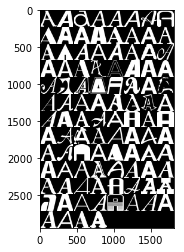

In [14]:
composed_transform = transforms.Compose([transforms.Scale((224,224)),transforms.ToTensor()])
train_dataset = CDATA(root_dir='./notMNIST_small', train=True, transform=composed_transform) # Supply proper root_dir
test_dataset = CDATA(root_dir='./notMNIST_small', train=False, transform=composed_transform) # Supply proper root_dir

# Let's check the size of the datasets, if implemented correctly they should be 16854 and 1870 respectively
print('Size of train dataset: %d' % len(train_dataset))
print('Size of test dataset: %d' % len(test_dataset))

# Create loaders for the dataset
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


# Let's look at one batch of train and test images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
train_dataiter = iter(train_loader)
train_images, train_labels = train_dataiter.next()
print("Train images")
imshow(torchvision.utils.make_grid(train_images))

test_dataiter = iter(test_loader)
test_images, test_labels = test_dataiter.next()
print("Test images")
imshow(torchvision.utils.make_grid(test_images))

### VGG-16 and Resnet-18
Now that you have created the dataset we can use it for training and testing neural networks. VGG-16 and Resnet-18 are both well-known deep-net architectures. VGG-16 is named as such since it has 16 layers in total (13 convolution and 3 fully-connected). Resnet-18 on the other hand is a Resnet architecture that uses skip-connections. PyTorch provides pre-trained models of both these architectures and we shall be using them directly. If you are interested in knowing how they have been defined do take a look at the source, [VGG](https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py), [Resnet](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py)

In [15]:
# vgg16 = models.vgg16(pretrained=True)

# for param in vgg16.parameters():
#     param.requires_grad = False

# vgg16.classifier = nn.Sequential(
#     nn.Linear(512*7*7, 4096),
#     nn.ReLU(True),
#     nn.Dropout(),
#     nn.Linear(4096, 4096),
#     nn.ReLU(True),
#     nn.Dropout(),
#     nn.Linear(4096, 10),
# )

#vgg16.cuda()



    
resnet18 = models.resnet18(pretrained=True)

for param in resnet18.parameters():
    param.requires_grad = False

resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)
resnet18.cuda()

ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

Define loss functions and optimizers

In [16]:
criterion = nn.CrossEntropyLoss().cuda()
optimizer_resnet18 = torch.optim.Adam(resnet18.fc.parameters(), lr = learning_rate)

#### Finetuning
Finetuning is nothing but training models after their weights have been loaded. This allows us to start at a better position than training from scratch. Since the models created already have weights loaded, you simply need to write a training loop.

In [17]:
# def train_vgg16():
#     # Write loops so as to train the model for N epochs, use num_epochs hyper parameter
#     # Train/finetune the VGG-16 network
#     # Store the losses for every epoch and generate a graph using matplotlib

    
    
def train_resnet18():
    
    # loss_epoch gives the loss calculated by the model at the end of each epoch
    loss_epoch = np.array([])
    
    for epoch in range(num_epochs):
        resnet18.train()        
        for i, (input1,target) in enumerate(train_loader):
            
            input_var = torch.autograd.Variable(input1).cuda()            
            target = target.cuda(async = True)
            target_var = torch.autograd.Variable(target)   
            
            output = resnet18(input_var)            
            loss = criterion(output, target_var)
            optimizer_resnet18.zero_grad()
            loss.backward()
            optimizer_resnet18.step()            
            
            output = output.float()
            loss = loss.float()
            
        loss_epoch = np.concatenate((loss_epoch,loss.cpu().data.numpy()))
    
    plt.plot(loss_epoch)
    plt.show()

Now let us start the training/finetuning

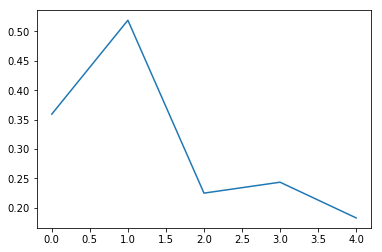

CPU times: user 19min 34s, sys: 3min 38s, total: 23min 12s
Wall time: 18min 10s


In [18]:
#%time train_vgg16()
%time train_resnet18()

#### Testing
Once finetuning is done we need to test it on the test set.

In [19]:
def test(model):
    
    correct = 0
    total = 0
    
    for i, (input1,target) in enumerate(test_loader):
            
            input_var = torch.autograd.Variable(input1,volatile = True).cuda()
            target = target.cuda(async = True)
            target_var = torch.autograd.Variable(target)
                        
            output = model(input_var)
            output = output.float()
            
            # t1 gives the array of predicted classes and t2 is the array of original class 
            t1 = output.max(1)[1].cpu().data.numpy()
            t2 = target_var.cpu().data.numpy()
            
            # Updating both the total and correct by adding the total no. of images in this batch as well as the
            # correctly classified images in this class
            correct += sum(t1==t2)
            total += len(t2)
            
    print('Accuracy: '+str(correct*100.0/total))

Test the model

In [20]:
#%time test(vgg16)
%time test(resnet18)

Accuracy: 30.5347593583
CPU times: user 29.5 s, sys: 5.74 s, total: 35.2 s
Wall time: 28.5 s


You can add more code to save the models if you want but otherwise this notebook is complete